# Prepyto semi automatic pipeline

In [2]:
import prepyto
import numpy as np
import napari
import tqdm
import skimage
import matplotlib.pyplot as plt

In [3]:
dataset_directory = "/Users/bzuber/Microscopic Anatomy Dropbox/Benoit Zuber/projects/deepvesicle/data/102_4e_trimmed"

In [7]:
pl = prepyto.Pipeline(dataset_directory)
pl.setup_prepyto_dir()


Prepyto Pipeline: the pipeline is created for /Users/bzuber/Microscopic Anatomy Dropbox/Benoit Zuber/projects/deepvesicle/data/102_4e_trimmed
Prepyto Pipeline: setting up prepyto directory


## Run the deep vesicle? 
if you haven't ran the next cell for this dataset, then do it (you'll need a GPU);

otherwise skip it and run the next one.

In [ ]:
pl.run_deep_at_multiple_rescale()

In [9]:
pl.set_array('deep_mask')

'deep_mask'

## label statistics
We can select the best initial threshold for making spheres based on statistics

In [23]:
diameter_dict = {}
for threshold in tqdm.tqdm(np.arange(0.9,1,0.01)):
    image_label = skimage.morphology.label(pl.deep_mask>threshold)
    area = skimage.measure.regionprops_table(image_label, properties=('bbox_area',))['bbox_area']
    diameter_dict[threshold] = area**(1/3)/pl.voxel_size

100%|██████████| 10/10 [00:25<00:00,  2.56s/it]


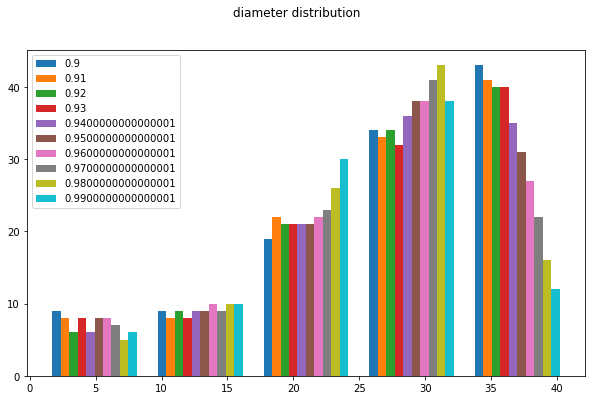

In [24]:
fig = plt.figure(figsize=(10,6))
fig.suptitle("diameter distribution")
_ = plt.hist(list(diameter_dict.values())[::1], label=list(diameter_dict.keys())[::1],bins=5)
_ = plt.legend()

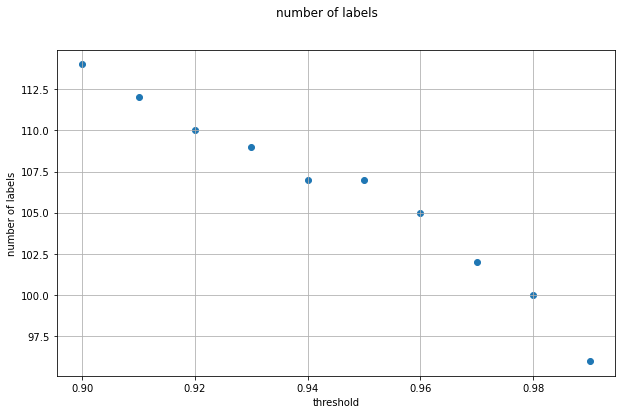

In [25]:
fig = plt.figure(figsize=(10,6))
fig.suptitle("number of labels")
plt.xlabel("threshold")
plt.ylabel("number of labels")
plt.grid()
plt.scatter(x=list(diameter_dict.keys()), y=[len(v) for v in list(diameter_dict.values())])

## How to chose the optimal starting threshold
The higher the threshold, the lower the false positive but the higher the false negative. 
There is no single best threshold. 

On our test dataset, a threshold of 0.96 found most of the vesicles and gave only few false positives.

In [4]:
pl.label_vesicles_simply(threshold=0.96)

Prepyto Pipeline: running label_vesicles_simply
Prepyto Pipeline: restricting labels to segmentation region
last output array name: deep_mask
last mrc file saved : prepyto/Dummy_102.rec_zoomed_mask.mrc


Expanding labels until none is too small:  17%|█▋        | 1/6 [00:12<01:02, 12.55s/it]


last output array name: deep_labels
last mrc file saved : prepyto/Dummy_102.rec_deep_labels.mrc


In [5]:
pl.make_spheres()

Prepyto Pipeline: Making vesicles spherical.


fitting sphere to vesicles: 100%|██████████| 104/104 [00:06<00:00, 16.94it/s]


last output array name: sphere_labels
last mrc file saved : prepyto/Dummy_102.rec_sphere.mrc


### optional visualization of deep_labels and sphere_labels

In [6]:
pl.visualization_old_new('deep_labels','sphere_labels')

Prepyto Pipeline: visualizing two sets of labels. To continue, close napari window


### Outlier detection
Detect outliers using multivariate statistics on 3 parameters of the detected spheres. We get a list of the most deviating labels (those that have a mahalanobis distance larger than min_mahalanobis_distance). So far the default min_mahalanobis_distance of 2.0 is good. If the red line on the plot does not include enough outliers to your liking, then use a lower value (optional parameter of pl.identify_sphere_outliers).

array([[<AxesSubplot:title={'center':'thickness'}>,
        <AxesSubplot:title={'center':'density'}>],
       [<AxesSubplot:title={'center':'radius'}>,
        <AxesSubplot:title={'center':'mahalanobis'}>]], dtype=object)

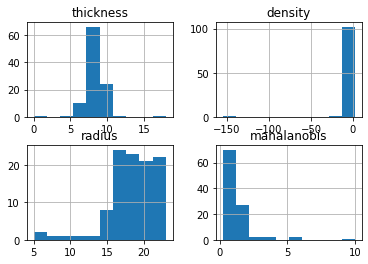

In [7]:
pl.sphere_df.hist()

       thickness     density  radius           center  mahalanobis
label                                                             
57             8    2.155889      12  [122, 444, 477]     2.310506
11             6    2.535230      10   [56, 385, 447]     3.156293
99             6  -18.772727       5  [189, 725, 323]     3.990640
104           12   -8.060606       8  [206, 371, 297]     4.076634
55             0    2.335685      13  [120, 395, 187]     5.174906
8             18   -0.806005      17   [41, 387, 449]     5.690268
1              4 -154.854430       5   [26, 553, 268]     9.998178
You should inspect the labels that have a high mahalanobis distance as they are the likeliest to be wrongly segmented


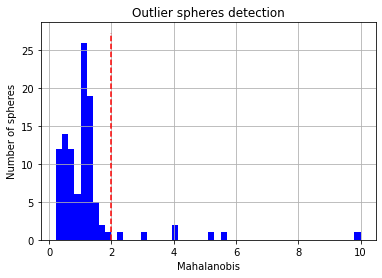

In [8]:
pl.identify_spheres_outliers(min_mahalanobis_distance=2)

In [9]:
pl.fix_spheres_interactively()

last output array name: mancorr_labels
last mrc file saved : prepyto/Dummy_102.rec_mancorr.mrc


In [10]:
pl.visualization_old_new('sphere_labels','mancorr_labels')

Prepyto Pipeline: visualizing two sets of labels. To continue, close napari window


It is recommended to compute a new sphere dataframe (which is one of the steps of make_spheres()) in order to identify remaining outliers.

In [11]:
pl.compute_sphere_dataframe('mancorr_labels')

fitting sphere to vesicles: 100%|██████████| 99/99 [00:02<00:00, 39.18it/s]


array([[<AxesSubplot:title={'center':'thickness'}>,
        <AxesSubplot:title={'center':'density'}>],
       [<AxesSubplot:title={'center':'radius'}>,
        <AxesSubplot:title={'center':'mahalanobis'}>]], dtype=object)

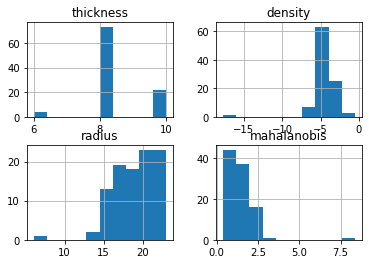

In [12]:
pl.sphere_df.hist()

       thickness   density  radius           center  mahalanobis
label                                                           
88            10 -5.037697      22  [211, 354, 398]     2.076607
28             8 -6.061285      17  [107, 367, 137]     2.080064
9              8 -4.930504      15   [62, 831, 363]     2.097253
87            10 -3.923858      17  [204, 545, 382]     2.099355
81            10 -5.292155      22  [200, 387, 188]     2.182538
89            10 -3.196447      17  [208, 864, 360]     2.195112
26            10 -2.647040      20  [104, 156, 431]     2.196096
55             8 -5.957868      16  [145, 286, 320]     2.305780
14            10 -2.860914      17   [83, 668, 452]     2.312807
16            10 -5.667855      22   [92, 247, 318]     2.378213
51             6 -4.629148      18  [140, 314, 458]     2.446046
24             6 -4.356322      19  [103, 578, 325]     2.454497
7             10 -5.805753      19   [64, 207, 315]     2.464764
60             8 -6.70120

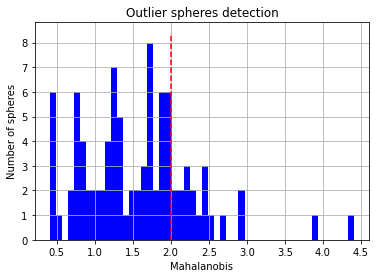

In [8]:
pl.identify_spheres_outliers()

In [18]:
pl.sphere_df[pl.sphere_df.radius<10]

,thickness,density,radius,center,mahalanobis
label,,,,,
99,8,-17.727273,6,"[189, 726, 322]",8.375738


In [ ]:
pl.fix_spheres_interactively('mancorr_labels')

In [10]:
pl.compute_sphere_dataframe('mancorr_labels')

fitting sphere to vesicles: 100%|██████████| 90/90 [00:02<00:00, 32.32it/s]


       thickness   density  radius           center  mahalanobis
label                                                           
17            10 -3.760571      22   [89, 676, 373]     2.044289
88            10 -5.037697      22  [211, 354, 398]     2.075853
9              8 -4.930504      15   [62, 831, 363]     2.075870
71             8 -2.658918      17  [168, 838, 434]     2.083092
73            10 -3.407016      18  [176, 707, 384]     2.095814
28             8 -6.061285      17  [107, 367, 137]     2.160959
87            10 -3.923858      17  [204, 545, 382]     2.166846
81            10 -5.292155      22  [200, 387, 188]     2.186120
95             8 -3.031496      23  [108, 723, 337]     2.301953
55             8 -5.957868      16  [145, 286, 320]     2.351856
89            10 -3.196447      17  [208, 864, 360]     2.371099
16            10 -5.667855      22   [92, 247, 318]     2.396402
26            10 -2.647040      20  [104, 156, 431]     2.445564
24             6 -4.35632

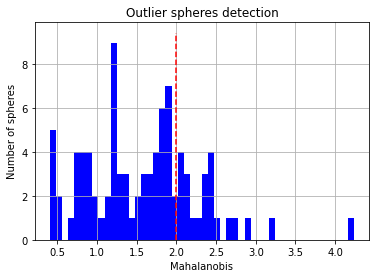

In [11]:
pl.identify_spheres_outliers()

In [14]:
pl.visualization_old_new('sphere_labels','mancorr_labels')

Prepyto Pipeline: visualizing two sets of labels. To continue, close napari window


In [16]:
pl.make_full_modfile()
pl.make_full_label_file()
pl.initialize_pyto()

Prepyto Pipeline: making full mod file
rearranged labels
last output array name: final_vesicle_labels
last mrc file saved : prepyto/Dummy_102.rec_final_vesicle_labels.mrc
full model file saved to prepyto/full_prepyto.mod
Prepyto Pipeline: making full label file
saved labels to prepyto/labels.mrc
Prepyto Pipeline: setting up pyto folder
/Users/bzuber/Microscopic Anatomy Dropbox/Benoit Zuber/projects/deepvesicle/data/102_4e_trimmed/pyto exists. Skipping pyto file creation. To force reinitialization of pyto folder, set overwrite to True
